# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler ,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from statsmodels.tsa.seasonal import seasonal_decompose

from tensorflow.keras.utils import timeseries_dataset_from_array

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,LSTM,GRU,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error,mean_absolute_error

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [4]:
# # Here is a helping code that will download and unzip the dataset for you.
# # Once you download the dataset you may comment the code!
# !kaggle datasets download -d khaledzsa/traffic-dataset
# !unzip traffic-dataset.zip

In [5]:
df=pd.read_csv('/content/Traffic Data.csv')

## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [6]:
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00
...,...,...,...,...,...,...,...,...
19995,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,2018-06-06 21:00:00
19996,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,2017-10-25 15:00:00
19997,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,2018-03-28 23:00:00
19998,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds,2018-02-12 15:00:00


In [7]:
df.sample(10)

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
10273,5134.0,290.43,0.25,0.0,75,Rain,light rain,2018-08-29 12:00:00
19337,986.0,259.58,0.00,0.0,40,Mist,mist,2018-02-04 01:00:00
3121,317.0,272.58,0.00,0.0,1,Clear,sky is clear,2017-11-27 01:00:00
19540,304.0,280.02,0.00,0.0,90,Drizzle,drizzle,2016-11-28 01:00:00
6112,2448.0,269.75,0.00,0.0,90,Mist,mist,2017-03-03 22:00:00
13546,3602.0,273.84,0.00,0.0,90,Clouds,overcast clouds,2018-03-10 21:00:00
19248,5360.0,264.01,0.00,0.0,75,Snow,light snow,2017-12-14 09:00:00
12272,4045.0,294.43,0.00,0.0,1,Clear,sky is clear,2018-07-21 10:00:00
17110,633.0,285.64,0.00,0.0,20,Clouds,few clouds,2018-05-10 00:00:00
6071,6148.0,265.73,0.00,0.0,40,Clouds,scattered clouds,2018-04-02 07:00:00


In [8]:
df['weather_main'].value_counts()

,count
weather_main,
Clear,5614
Clouds,5234
Mist,2758
Rain,2244
Snow,1462
Drizzle,993
Haze,672
Thunderstorm,542
Fog,478


In [9]:
df['weather_description'].value_counts()

,count
weather_description,
sky is clear,5514
mist,2758
overcast clouds,1738
broken clouds,1574
scattered clouds,1458
light snow,1247
light rain,1201
moderate rain,747
haze,672


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
 7   date_time            20000 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.2+ MB


In [11]:
df['snow_1h'].value_counts()

,count
snow_1h,
0.0,20000


In [12]:
df=df.drop(columns='snow_1h')

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [13]:
df=df.dropna()

In [14]:
df.duplicated().sum()

12

In [15]:
df=df.drop_duplicates()

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [17]:
df['diff_traffic_volume']=df['traffic_volume'].diff()

In [18]:
df['prev_traffic_volume']=df['traffic_volume'].shift(7)

In [19]:
df['date']=pd.to_datetime(df['date_time']).dt.date
df['Day of the week']=pd.to_datetime(df['date_time']).dt.day_of_week
df['Day of the year']=pd.to_datetime(df['date_time']).dt.day_of_year
df['Month']=pd.to_datetime(df['date_time']).dt.month

In [20]:
df=df.set_index(df['date'])

In [21]:
df=df.sort_index()

In [22]:
df.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'diff_traffic_volume',
       'prev_traffic_volume', 'date', 'Day of the week', 'Day of the year',
       'Month'],
      dtype='object')

In [23]:
Encoder=OneHotEncoder(sparse=False)
scaler=MinMaxScaler()
imputer=SimpleImputer(strategy='mean')

num=make_pipeline(imputer,scaler)
cat=make_pipeline(Encoder)

pipe=make_column_transformer(
    (num,['diff_traffic_volume','prev_traffic_volume','traffic_volume','temp', 'rain_1h', 'clouds_all', 'Day of the week',
       'Day of the year', 'Month']),
    (cat,['weather_main',
       'weather_description'])
)
pipe

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['diff_traffic_volume', 'prev_traffic_volume',
                                  'traffic_volume', 'temp', 'rain_1h',
                                  'clouds_all', 'Day of the week',
                                  'Day of the year', 'Month']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(sparse=False))]),
                                 ['weather_main', 'weather_description'])])

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [24]:
df=df.drop(columns=['date_time'])

In [25]:
df

,traffic_volume,temp,rain_1h,clouds_all,weather_main,weather_description,diff_traffic_volume,prev_traffic_volume,date,Day of the week,Day of the year,Month
date,,,,,,,,,,,,
2016-11-18,2160.0,273.47,0.0,90,Snow,light snow,-705.0,3897.0,2016-11-18,4,323,11
2016-11-18,3486.0,273.59,0.0,90,Snow,heavy snow,-1203.0,5709.0,2016-11-18,4,323,11
2016-11-18,4328.0,273.62,0.0,90,Fog,fog,-551.0,5086.0,2016-11-18,4,323,11
2016-11-18,2027.0,273.28,0.0,90,Snow,light snow,-3043.0,4984.0,2016-11-18,4,323,11
2016-11-18,3486.0,273.59,0.0,90,Mist,mist,2645.0,4913.0,2016-11-18,4,323,11
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30,802.0,280.17,0.0,90,Clouds,overcast clouds,-3523.0,2894.0,2018-09-30,6,273,9
2018-09-30,1450.0,282.09,0.0,90,Clouds,overcast clouds,-1577.0,4762.0,2018-09-30,6,273,9
2018-09-30,4283.0,284.38,0.0,75,Rain,light rain,-44.0,2042.0,2018-09-30,6,273,9


In [26]:
train,test_val=train_test_split(df,test_size=0.3,shuffle=False)

test,val=train_test_split(test_val,test_size=0.5,shuffle=False)

index=train.index

In [27]:
train.head()

,traffic_volume,temp,rain_1h,clouds_all,weather_main,weather_description,diff_traffic_volume,prev_traffic_volume,date,Day of the week,Day of the year,Month
date,,,,,,,,,,,,
2016-11-18,2160.0,273.47,0.0,90,Snow,light snow,-705.0,3897.0,2016-11-18,4,323,11
2016-11-18,3486.0,273.59,0.0,90,Snow,heavy snow,-1203.0,5709.0,2016-11-18,4,323,11
2016-11-18,4328.0,273.62,0.0,90,Fog,fog,-551.0,5086.0,2016-11-18,4,323,11
2016-11-18,2027.0,273.28,0.0,90,Snow,light snow,-3043.0,4984.0,2016-11-18,4,323,11
2016-11-18,3486.0,273.59,0.0,90,Mist,mist,2645.0,4913.0,2016-11-18,4,323,11


In [28]:
train.shape

(13977, 12)

{'whiskers': [<matplotlib.lines.Line2D at 0x7c982133b3a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7c982133b8e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7c982133b100>,
 'medians': [<matplotlib.lines.Line2D at 0x7c982133be20>,
 'fliers': [<matplotlib.lines.Line2D at 0x7c9821384100>,
 'means': []}

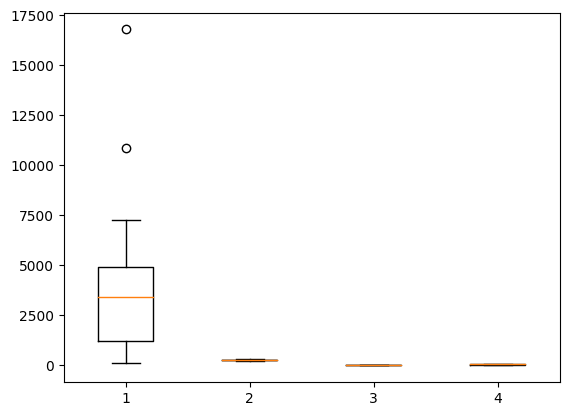

In [29]:
plt.boxplot(train[['traffic_volume','temp', 'rain_1h', 'clouds_all']])

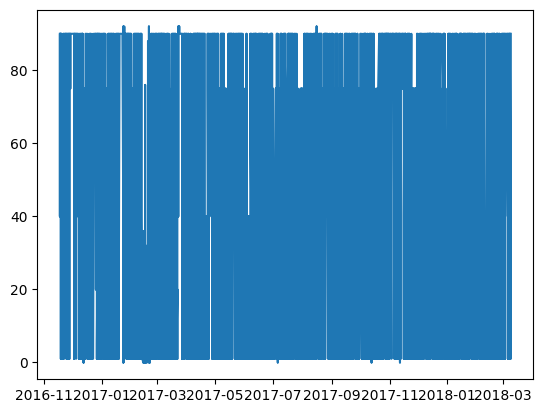

In [30]:
plt.plot(train['clouds_all'])

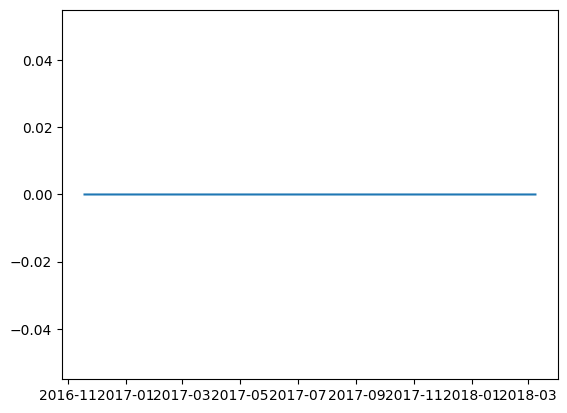

In [31]:
plt.plot(train['rain_1h'])

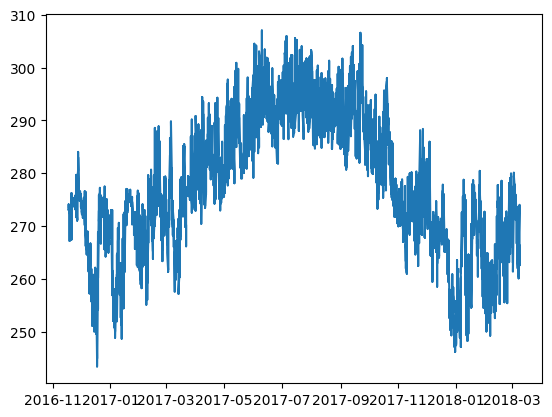

In [32]:
plt.plot(train['temp'])

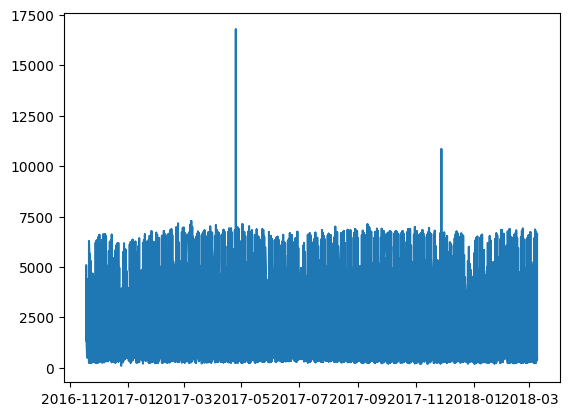

In [33]:
plt.plot(train['traffic_volume'])

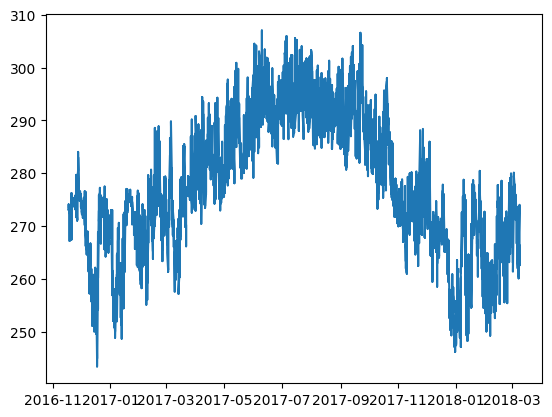

In [34]:
plt.plot(train['temp'])

In [35]:
train1=train.dropna()

In [36]:
S=seasonal_decompose(train1['traffic_volume'],model='additive', period=365)

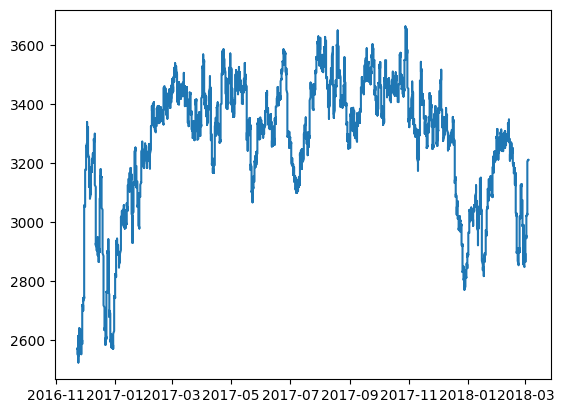

In [37]:
plt.plot(S.trend)

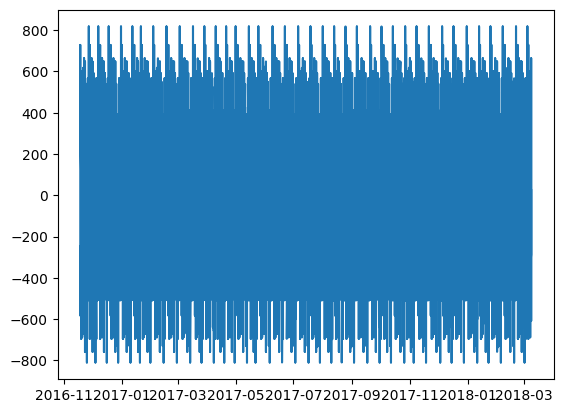

In [38]:
plt.plot(S.seasonal)

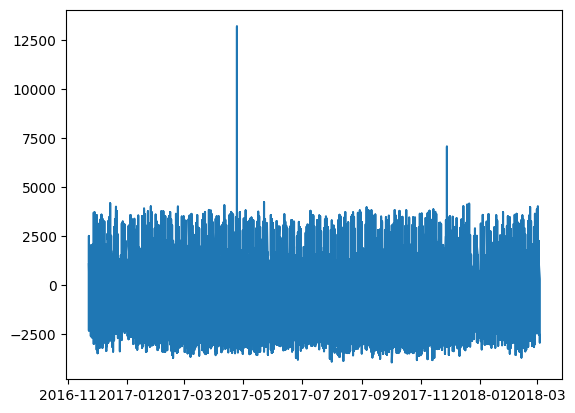

In [39]:
plt.plot(S.resid)

In [80]:
S2=seasonal_decompose(train1['temp'],model='additive', period=365)

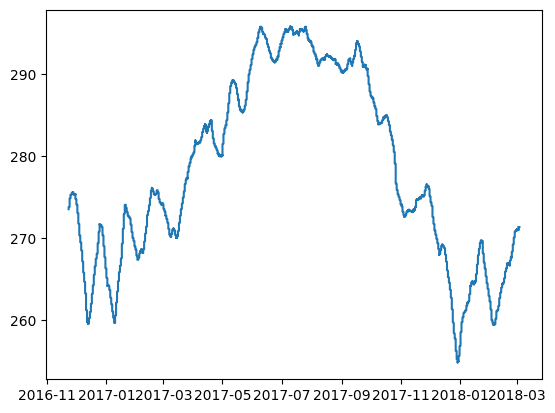

In [81]:
plt.plot(S2.trend)

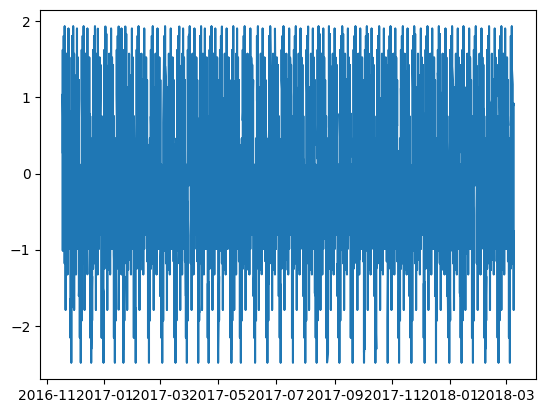

In [82]:
plt.plot(S2.seasonal)

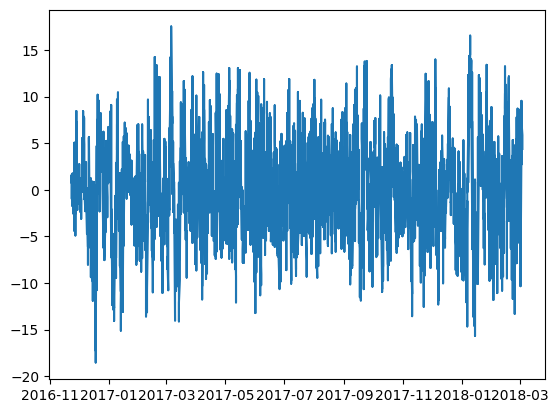

In [83]:
plt.plot(S2.resid)

In [84]:
S3=seasonal_decompose(train1['clouds_all'],model='additive', period=365)

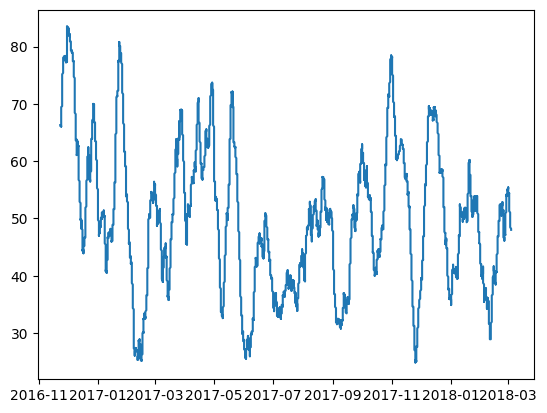

In [85]:
plt.plot(S3.trend)

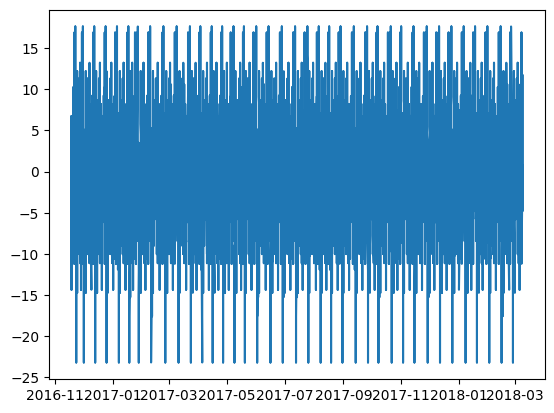

In [86]:
plt.plot(S3.seasonal)

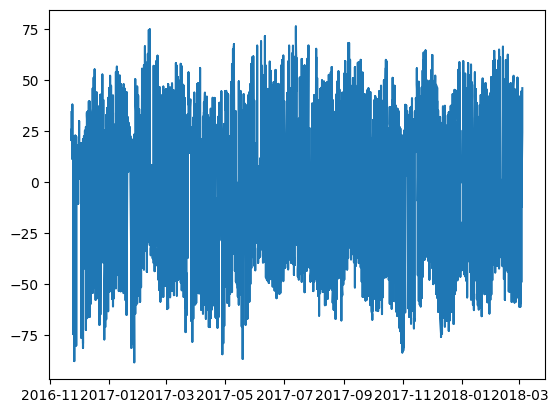

In [87]:
plt.plot(S3.resid)

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [40]:
train_S=pipe.fit_transform(train)
test_S=pipe.transform(test)
val_S=pipe.transform(val)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [41]:
train_S.shape

(13977, 53)

In [48]:
window_size=30

train_data=timeseries_dataset_from_array(train_S,targets=train_S[window_size:],sequence_length=window_size,batch_size=32)

test_data=timeseries_dataset_from_array(test_S,targets=test_S[window_size:],sequence_length=window_size,batch_size=32)

val_data=timeseries_dataset_from_array(val_S,targets=val_S[window_size:],sequence_length=window_size,batch_size=32)

In [63]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 53), dtype=tf.float64, name=None), TensorSpec(shape=(None, 53), dtype=tf.float64, name=None))>

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [49]:
modelRNN=Sequential([
    SimpleRNN(50,activation='tanh',return_sequences=True),
    Dropout(0,2),
    SimpleRNN(50,activation='tanh'),
    Dense(1)
])

EarlyStopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

modelRNN.compile(optimizer='adam',loss='mse',metrics=['mae'])

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [50]:
history1=modelRNN.fit(train_data,epochs=10,batch_size=32,validation_data=val_data,callbacks=EarlyStopping)

Epoch 1/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.1472 - mae: 0.2536 - val_loss: 0.0979 - val_mae: 0.1971
Epoch 2/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0730 - mae: 0.1762 - val_loss: 0.0969 - val_mae: 0.1876
Epoch 3/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0727 - mae: 0.1761 - val_loss: 0.0967 - val_mae: 0.1821
Epoch 4/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0727 - mae: 0.1762 - val_loss: 0.0966 - val_mae: 0.1807
Epoch 5/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0726 - mae: 0.1761 - val_loss: 0.0966 - val_mae: 0.1770
Epoch 6/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0727 - mae: 0.1761 - val_loss: 0.0966 - val_mae: 0.1757
Epoch 7/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0726 - mae: 0.1761 - val_loss: 0.0965 - val_mae: 0.1758
Epoch 8/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0726 - mae: 0.1761 - val_loss: 0.0965 - val_mae: 0.1756
Epoch 9/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 11s

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [51]:
pred=modelRNN.predict(test_data)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [70]:
mse=mean_squared_error(test_data,pred)
nae=mean_absolute_error(test_data,pred)

ValueError: Found input variables with inconsistent numbers of samples: [93, 2965]

In [67]:
modelRNN.evaluate(test_data)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0611 - mae: 0.1471


[0.06416135281324387, 0.15248148143291473]

<Axes: >

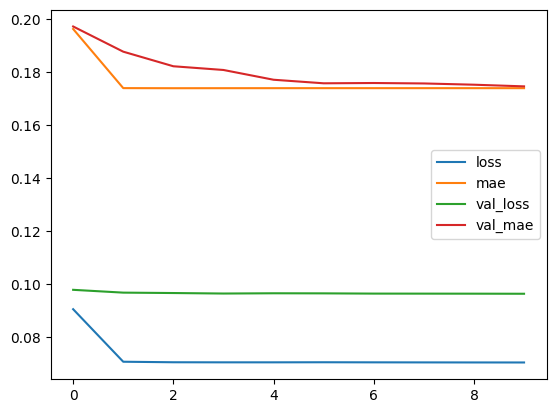

In [55]:
pd.DataFrame(history1.history).plot()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [56]:
modelLSTM=Sequential([
    LSTM(50,activation='tanh',return_sequences=True),
    Dropout(0,2),
    LSTM(50,activation='tanh'),
    Dense(1)
])

modelLSTM.compile(optimizer='adam',loss='mse',metrics=['mae'])

In [57]:
history2=modelLSTM.fit(train_data,epochs=10,batch_size=32,validation_data=val_data,callbacks=EarlyStopping)

Epoch 1/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - loss: 0.0761 - mae: 0.1807 - val_loss: 0.0933 - val_mae: 0.1941
Epoch 2/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 0.0726 - mae: 0.1763 - val_loss: 0.0934 - val_mae: 0.1907
Epoch 3/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - loss: 0.0726 - mae: 0.1762 - val_loss: 0.0935 - val_mae: 0.1868
Epoch 4/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 0.0725 - mae: 0.1761 - val_loss: 0.0935 - val_mae: 0.1882
Epoch 5/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 0.0725 - mae: 0.1761 - val_loss: 0.0937 - val_mae: 0.1842
Epoch 6/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 0.0725 - mae: 0.1761 - val_loss: 0.0936 - val_mae: 0.1841


### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [68]:
pred=modelLSTM.predict(test_data)

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [77]:
mse=mean_squared_error(test_data,pred)
nae=mean_absolute_error(test_data,pred)

ValueError: Found input variables with inconsistent numbers of samples: [93, 2965]

In [66]:
modelLSTM.evaluate(test_data)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0609 - mae: 0.1546


[0.06381230801343918, 0.1615912765264511]

<Axes: >

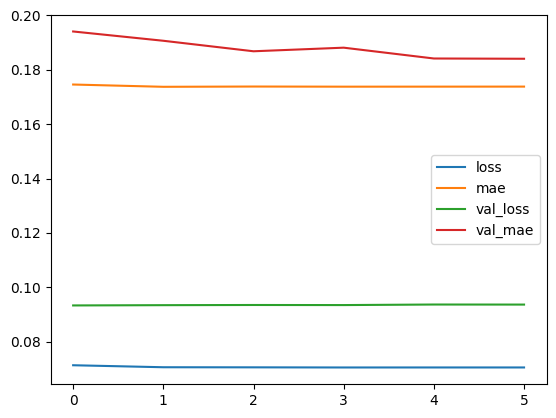

In [60]:
pd.DataFrame(history2.history).plot()

### Model 3

In [61]:
modelGRU=Sequential([
    GRU(50,activation='tanh',return_sequences=True),
    Dropout(0,2),
    GRU(50,activation='tanh'),
    Dense(1)
])

modelGRU.compile(optimizer='adam',loss='mse',metrics=['mae'])

In [62]:
history3=modelLSTM.fit(train_data,epochs=10,batch_size=32,validation_data=val_data,callbacks=EarlyStopping)

Epoch 1/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 0.0729 - mae: 0.1761 - val_loss: 0.0940 - val_mae: 0.1822
Epoch 2/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 0.0725 - mae: 0.1760 - val_loss: 0.0936 - val_mae: 0.1856
Epoch 3/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 0.0725 - mae: 0.1760 - val_loss: 0.0938 - val_mae: 0.1843
Epoch 4/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 0.0725 - mae: 0.1760 - val_loss: 0.0937 - val_mae: 0.1843
Epoch 5/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 0.0725 - mae: 0.1760 - val_loss: 0.0938 - val_mae: 0.1836


In [69]:
pred=modelGRU.predict(test_data)

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


In [76]:
mse=mean_squared_error(test_data,pred)
nae=mean_absolute_error(test_data,pred)

ValueError: Found input variables with inconsistent numbers of samples: [93, 2965]

In [65]:
modelGRU.evaluate(test_data)

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0646 - mae: 0.1693


[0.06718429923057556, 0.16752511262893677]

<Axes: >

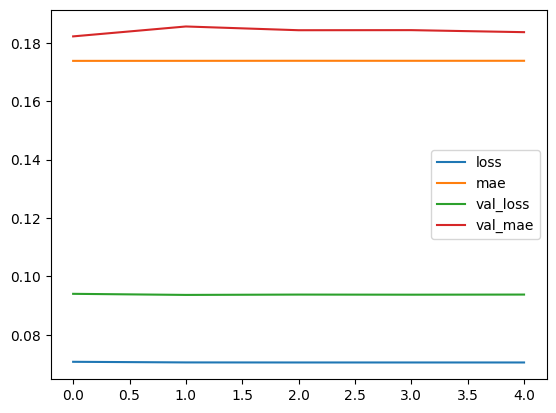

In [64]:
pd.DataFrame(history3.history).plot()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:
1. **Data Preprocessing**: for data preprosessing i used pipeline and MinMax scaler for normlization the data and one hot encoder for numric the data and simple imputer for handling missing values

2. **Feature Engineering**: i crate new fetures ('date',	'Day of the week',	'Day of the year',	'Month') from 'date-time'
and ('diff_traffic_volume','prev_traffic_volume') from 'traffic_volume'
these features will make the data more complex and more accurate

3. **Model Architecture**: i used 3 model’s architecture [Simple RNN,LSTM,GRU] because these models are gives high performance on time series forecasting problems .
and i use same layers, number of neurons and activation functions so i can chose the best model for these data and then the best one will apply hyperparameter tuning.
the best model was RNN

4. **Training Process**:
the optimizer 'adam' is the best one for now
batch size and number of epochs are hyperparameters

7. **Overfitting and Underfitting**: there is underfitting during training.
the hyperparameter tuning enhance model performance

8. **Future Improvements**:
1-useing ARIMA model maybe will enhance model performance
2-use hyperparameter tuning
